## 1.Import Libraries

In [72]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import(
OneHotEncoder,
StandardScaler,
MinMaxScaler,
PowerTransformer,
FunctionTransformer,
OrdinalEncoder
)

from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
RareLabelEncoder,
MeanEncoder,
CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures

import warnings

import matplotlib.pyplot as plt


## 2.Display Settings

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

## 3.Read The Data

In [5]:
path=r"C:\Users\vinay\OneDrive\Desktop\flights-sagemaker-project\Data\train.csv"
train=pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Spicejet,2019-06-03,Kolkata,Banglore,17:10:00,19:40:00,150,0.0,No check-in baggage included,3841
1,Spicejet,2019-06-12,Kolkata,Banglore,15:05:00,20:20:00,315,1.0,No Info,4649
2,Jet Airways,2019-04-06,Banglore,Delhi,19:50:00,22:50:00,180,0.0,No Info,7229
3,Multiple Carriers,2019-06-15,Delhi,Cochin,13:00:00,19:15:00,375,1.0,No Info,16108
4,Jet Airways,2019-03-24,Kolkata,Banglore,18:55:00,16:20:00,1285,1.0,No Info,14231
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-05-18,Delhi,Cochin,20:30:00,23:00:00,1590,1.0,No Info,8907
636,Jet Airways,2019-05-06,Kolkata,Banglore,17:00:00,15:05:00,1325,1.0,No Info,13067
637,Spicejet,2019-05-18,Kolkata,Banglore,11:35:00,18:50:00,435,1.0,No Info,8479
638,Goair,2019-03-24,Kolkata,Banglore,16:25:00,00:05:00,460,1.0,No Info,10198


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train=train.drop(columns="price")
y_train=train.price.copy()

## 4.Transformation Operations

### 4.1 airline

In [8]:
X_train.airline

0               Spicejet
1               Spicejet
2            Jet Airways
3      Multiple Carriers
4            Jet Airways
             ...        
635            Air India
636          Jet Airways
637             Spicejet
638                Goair
639            Air India
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="others",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_others
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,0.0,0.0,0.0,1.0
638,0.0,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [10]:
train.date_of_journey

0      2019-06-03
1      2019-06-12
2      2019-04-06
3      2019-06-15
4      2019-03-24
          ...    
635    2019-05-18
636    2019-05-06
637    2019-05-18
638    2019-03-24
639    2019-06-06
Name: date_of_journey, Length: 640, dtype: object

In [11]:
feature_to_extract=["month","week","day_of_week","day_of_year"]

doj_transformer=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format="mixed")),
    ("scalar",MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.823529,0.000000,0.796610
1,1.000000,0.882353,0.333333,0.872881
2,0.333333,0.294118,0.833333,0.305085
3,1.000000,0.882353,0.833333,0.898305
4,0.000000,0.176471,1.000000,0.194915
...,...,...,...,...
635,0.666667,0.647059,0.833333,0.661017
636,0.666667,0.588235,0.000000,0.559322
637,0.666667,0.647059,0.833333,0.661017
638,0.000000,0.176471,1.000000,0.194915


### 4.3 Source & Destination

In [12]:
X_train.source

0       Kolkata
1       Kolkata
2      Banglore
3         Delhi
4       Kolkata
         ...   
635       Delhi
636     Kolkata
637     Kolkata
638     Kolkata
639       Delhi
Name: source, Length: 640, dtype: object

In [13]:
X_train.destination

0      Banglore
1      Banglore
2         Delhi
3        Cochin
4      Banglore
         ...   
635      Cochin
636    Banglore
637    Banglore
638    Banglore
639      Cochin
Name: destination, Length: 640, dtype: object

In [14]:
location_subset=X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Kolkata,Banglore
1,Kolkata,Banglore
2,Banglore,Delhi
3,Delhi,Cochin
4,Kolkata,Banglore
...,...,...
635,Delhi,Cochin
636,Kolkata,Banglore
637,Kolkata,Banglore
638,Kolkata,Banglore


In [15]:
location_pipe1=Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,-0.477749,-0.450376
1,-0.477749,-0.450376
2,-0.742481,-1.817516
3,1.007115,1.010501
4,-0.477749,-0.450376
...,...,...
635,1.007115,1.010501
636,-0.477749,-0.450376
637,-0.477749,-0.450376
638,-0.477749,-0.450376


In [16]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [17]:
def  is_north(X):
    columns=X.columns.to_list()
    north_cities=["Delhi","Kolkata","Mumbai","New Delhi"]
    return(    
        X
        .assign(**{
            f"{col}_is_north": X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
##is_north(location_subset)
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [18]:
location_transformer=FeatureUnion(transformer_list=[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,-0.477749,-0.450376,1,0
1,-0.477749,-0.450376,1,0
2,-0.742481,-1.817516,0,1
3,1.007115,1.010501,1,0
4,-0.477749,-0.450376,1,0
...,...,...,...,...
635,1.007115,1.010501,1,0
636,-0.477749,-0.450376,1,0
637,-0.477749,-0.450376,1,0
638,-0.477749,-0.450376,1,0


### 4.4 dep_time & arrival_time

In [19]:
X_train.dep_time

0      17:10:00
1      15:05:00
2      19:50:00
3      13:00:00
4      18:55:00
         ...   
635    20:30:00
636    17:00:00
637    11:35:00
638    16:25:00
639    05:55:00
Name: dep_time, Length: 640, dtype: object

In [20]:
X_train.arrival_time

0      19:40:00
1      20:20:00
2      22:50:00
3      19:15:00
4      16:20:00
         ...   
635    23:00:00
636    15:05:00
637    18:50:00
638    00:05:00
639    19:15:00
Name: arrival_time, Length: 640, dtype: object

In [21]:
time_subset=X_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,17:10:00,19:40:00
1,15:05:00,20:20:00
2,19:50:00,22:50:00
3,13:00:00,19:15:00
4,18:55:00,16:20:00
...,...,...
635,20:30:00,23:00:00
636,17:00:00,15:05:00
637,11:35:00,18:50:00
638,16:25:00,00:05:00


In [22]:
time_pipe1=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.739130,0.181818,0.826087,0.727273
1,0.652174,0.090909,0.869565,0.363636
2,0.826087,0.909091,0.956522,0.909091
3,0.565217,0.000000,0.826087,0.272727
4,0.782609,1.000000,0.695652,0.363636
...,...,...,...,...
635,0.869565,0.545455,1.000000,0.000000
636,0.739130,0.000000,0.652174,0.090909
637,0.478261,0.636364,0.782609,0.909091
638,0.695652,0.454545,0.000000,0.090909


In [23]:
def part_of_day(X, morning=4,noon=12,eve=16,night=20):
    columns=X.columns.to_list()
    X_temp= X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    
    return (
    X_temp
    .assign(**{
        f"{col}_part_of_day" : np.select(
            [X_temp.loc[:,col].between(morning ,noon,inclusive ="left"),
            X_temp.loc[:,col].between(noon,eve,inclusive="left"),
            X_temp.loc[:,col].between(eve,night,inclusive="left")],
            ["morning","afternoon","evening"],
            default="night"
        )
        for col in columns    
    })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,evening
1,afternoon,night
2,evening,night
3,afternoon,evening
4,evening,evening
...,...,...
635,night,night
636,evening,afternoon
637,morning,evening
638,evening,night


In [24]:
time_pipe2=Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.214912,0.710526
1,0.000000,0.763158
2,0.214912,0.763158
3,0.000000,0.710526
4,0.214912,0.710526
...,...,...
635,0.171053,0.763158
636,0.214912,0.000000
637,1.000000,0.710526
638,0.214912,0.763158


In [25]:
time_transformer=FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.739130,0.181818,0.826087,0.727273,0.214912,0.710526
1,0.652174,0.090909,0.869565,0.363636,0.000000,0.763158
2,0.826087,0.909091,0.956522,0.909091,0.214912,0.763158
3,0.565217,0.000000,0.826087,0.272727,0.000000,0.710526
4,0.782609,1.000000,0.695652,0.363636,0.214912,0.710526
...,...,...,...,...,...,...
635,0.869565,0.545455,1.000000,0.000000,0.171053,0.763158
636,0.739130,0.000000,0.652174,0.090909,0.214912,0.000000
637,0.478261,0.636364,0.782609,0.909091,1.000000,0.710526
638,0.695652,0.454545,0.000000,0.090909,0.214912,0.763158


### 4.5 duration

In [26]:
X_train.duration

0       150
1       315
2       180
3       375
4      1285
       ... 
635    1590
636    1325
637     435
638     460
639     800
Name: duration, Length: 640, dtype: int64

In [27]:
(
    X_train
    .duration
    .quantile([0.25,0.50,0.75])
    .values
    .reshape(-1,1)
    .shape
)

(3, 1)

In [28]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.50,0.75],gamma=0.1):
        self.variables=variables
        self.percentiles=percentiles
        self.gamma=gamma

    def fit(self,X,y=None):
        if not self.variables:
            self.variables=X.select_dtypes(include="number").columns.to_list()

        self.reference_values_={
            col:(
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)  
            )
            for col in self.variables
        }
        return self

    def transform(self,X):
        objects=[]
        for col in self.variables:
            columns=[f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj=pd.DataFrame(
                data=rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns=columns
                )
            objects.append(obj)
        return pd.concat(objects,axis=1)

In [29]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,4.248354e-18,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00
2,4.539993e-05,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...
635,0.000000e+00,0.000000e+00,0.000000e+00
636,0.000000e+00,0.000000e+00,0.000000e+00
637,0.000000e+00,1.332222e-198,0.000000e+00
638,0.000000e+00,3.593844e-79,0.000000e+00


In [30]:
duration_pipe1=Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scalar",PowerTransformer())
])
duration_union=FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",StandardScaler())
])
duration_transformer=Pipeline(steps=[
    ("outliers",Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer",SimpleImputer(strategy="median")),
    ("union",duration_union)
])
duration_transformer.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.300686,-0.104946,-0.105032,-0.976119
1,-0.300686,-0.104946,-0.105032,-0.634147
2,-0.294261,-0.104946,-0.105032,-0.913942
3,-0.300686,-0.104946,-0.105032,-0.509793
4,-0.300686,-0.104946,-0.105032,1.376236
...,...,...,...,...
635,-0.300686,-0.104946,-0.105032,2.008367
636,-0.300686,-0.104946,-0.105032,1.459139
637,-0.300686,-0.104946,-0.105032,-0.385439
638,-0.300686,-0.104946,-0.105032,-0.333625


In [31]:
def duration_category(X,short=180,med=400):
    return(
        X
        .assign(duration_cat=np.select(
            [X.duration.lt(short),X.duration.between(short,med,inclusive ="left")],
            ["short","medium"],
            default="long"
        ))
        .drop(columns="duration")
    )

In [32]:
def is_over(X,value=1000):
    return(
        X
        .assign(**{
            f"duration_over_{value}":X.duration.ge(value).astype(int)
        })
        .drop(columns="duration")
    )

In [42]:
duration_pipe1=Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scalar",PowerTransformer())
])
duration_pipe2=Pipeline(steps=[
    ("cat",FunctionTransformer(func=duration_category)),
    ("encoder",OrdinalEncoder(categories=[["short","medium","long"]]))
])

duration_union=FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",duration_pipe2),
    ("part3",FunctionTransformer(func=is_over)),
    ("part4",StandardScaler())
])
duration_transformer=Pipeline(steps=[
    ("outliers",Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer",SimpleImputer(strategy="median")),
    ("union",duration_union)
])
duration_transformer.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.300686,-0.104946,-0.105032,0.0,0,-0.976119
1,-0.300686,-0.104946,-0.105032,1.0,0,-0.634147
2,-0.294261,-0.104946,-0.105032,1.0,0,-0.913942
3,-0.300686,-0.104946,-0.105032,1.0,0,-0.509793
4,-0.300686,-0.104946,-0.105032,2.0,1,1.376236
...,...,...,...,...,...,...
635,-0.300686,-0.104946,-0.105032,2.0,1,2.008367
636,-0.300686,-0.104946,-0.105032,2.0,1,1.459139
637,-0.300686,-0.104946,-0.105032,2.0,0,-0.385439
638,-0.300686,-0.104946,-0.105032,2.0,0,-0.333625


### 4.6 total_stops

In [43]:
X_train.total_stops

0      0.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    1.0
638    1.0
639    2.0
Name: total_stops, Length: 640, dtype: float64

In [44]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

total_stops_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("",FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,1.0,0


### 4.7 additional_info

In [45]:
X_train.additional_info

0      No check-in baggage included
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
635                         No Info
636                         No Info
637                         No Info
638                         No Info
639                         No Info
Name: additional_info, Length: 640, dtype: object

In [47]:
info_pipe1=Pipeline(steps=[
    ("group",RareLabelEncoder(tol=0.1,n_categories=2,replace_with="Other")),
    ("encoder",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])
info_pipe1.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [48]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [49]:
info_union=FeatureUnion(transformer_list=[
    ("part1",info_pipe1),
    ("part2",FunctionTransformer(func=have_info))
])

In [50]:
info_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="constant",fill_value="unknown")),
    ("union",info_union)
])

info_transformer.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,0.0,1.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


## 4.8 Column Transformer

In [51]:
column_transformer=ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"]),
    ("doj",doj_transformer,["date_of_journey"]),
    ("location",location_transformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("dur",duration_transformer,["duration"]),
    ("stops",total_stops_transformer,["total_stops"]),
    ("info",info_transformer,["additional_info"])
],remainder="passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_others,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.000000,0.796610,-0.477749,-0.450376,1,0,0.739130,0.181818,0.826087,0.727273,0.214912,0.710526,-0.300686,-0.104946,-0.105032,0.0,0,-0.976119,0.0,1,0.0,0.0,1.0,1
1,0.0,0.0,0.0,0.0,1.0,1.000000,0.882353,0.333333,0.872881,-0.477749,-0.450376,1,0,0.652174,0.090909,0.869565,0.363636,0.000000,0.763158,-0.300686,-0.104946,-0.105032,1.0,0,-0.634147,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.333333,0.294118,0.833333,0.305085,-0.742481,-1.817516,0,1,0.826087,0.909091,0.956522,0.909091,0.214912,0.763158,-0.294261,-0.104946,-0.105032,1.0,0,-0.913942,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,1.000000,0.882353,0.833333,0.898305,1.007115,1.010501,1,0,0.565217,0.000000,0.826087,0.272727,0.000000,0.710526,-0.300686,-0.104946,-0.105032,1.0,0,-0.509793,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-0.477749,-0.450376,1,0,0.782609,1.000000,0.695652,0.363636,0.214912,0.710526,-0.300686,-0.104946,-0.105032,2.0,1,1.376236,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,1.007115,1.010501,1,0,0.869565,0.545455,1.000000,0.000000,0.171053,0.763158,-0.300686,-0.104946,-0.105032,2.0,1,2.008367,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.477749,-0.450376,1,0,0.739130,0.000000,0.652174,0.090909,0.214912,0.000000,-0.300686,-0.104946,-0.105032,2.0,1,1.459139,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,-0.477749,-0.450376,1,0,0.478261,0.636364,0.782609,0.909091,1.000000,0.710526,-0.300686,-0.104946,-0.105032,2.0,0,-0.385439,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,0.0,0.0,1.0,0.000000,0.176471,1.000000,0.194915,-0.477749,-0.450376,1,0,0.695652,0.454545,0.000000,0.090909,0.214912,0.763158,-0.300686,-0.104946,-0.105032,2.0,0,-0.333625,1.0,0,0.0,1.0,0.0,0


## 5 Feature Selection

In [63]:
estimator= RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)

selector=SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
)

## 6. Putting It All Together

In [64]:
preprocessor=Pipeline(steps=[
    ("ct",column_transformer),
    ("selector",selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_others,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,1.0,0.823529,0.796610,-0.477749,-0.450376,-0.300686,0.0,0,-0.976119,0.0,1
1,0.0,0.0,1.0,0.882353,0.872881,-0.477749,-0.450376,-0.300686,1.0,0,-0.634147,1.0,0
2,0.0,1.0,0.0,0.294118,0.305085,-0.742481,-1.817516,-0.294261,1.0,0,-0.913942,0.0,1
3,0.0,0.0,0.0,0.882353,0.898305,1.007115,1.010501,-0.300686,1.0,0,-0.509793,1.0,0
4,0.0,1.0,0.0,0.176471,0.194915,-0.477749,-0.450376,-0.300686,2.0,1,1.376236,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.647059,0.661017,1.007115,1.010501,-0.300686,2.0,1,2.008367,1.0,0
636,0.0,1.0,0.0,0.588235,0.559322,-0.477749,-0.450376,-0.300686,2.0,1,1.459139,1.0,0
637,0.0,0.0,1.0,0.647059,0.661017,-0.477749,-0.450376,-0.300686,2.0,0,-0.385439,1.0,0
638,0.0,0.0,1.0,0.176471,0.194915,-0.477749,-0.450376,-0.300686,2.0,0,-0.333625,1.0,0


## 7 Visualizations

In [68]:
preprocessor.named_steps.keys()

dict_keys(['ct', 'selector'])

In [69]:
feature_performance=preprocessor.named_steps["selector"].feature_performance_
feature_performance

{'air__airline_Air India': np.float64(-0.0044620130541996135),
 'air__airline_Indigo': np.float64(0.1310341392907469),
 'air__airline_Jet Airways': np.float64(0.17913195133159343),
 'air__airline_Multiple Carriers': np.float64(0.025434687155143892),
 'air__airline_others': np.float64(0.13783120260451154),
 'doj__date_of_journey_month': np.float64(0.07383573040643791),
 'doj__date_of_journey_week': np.float64(0.17693031563447856),
 'doj__date_of_journey_day_of_week': np.float64(0.0027041603534766847),
 'doj__date_of_journey_day_of_year': np.float64(0.20466640360205635),
 'location__source': np.float64(0.13671734599145835),
 'location__destination': np.float64(0.12807196888211567),
 'location__source_is_north': np.float64(0.023032806039733716),
 'location__destination_is_north': np.float64(0.023032806039733716),
 'time__dep_time_hour': np.float64(-0.0006928366783300888),
 'time__dep_time_minute': np.float64(0.024421239857121486),
 'time__arrival_time_hour': np.float64(0.03315494763947124

In [70]:
sorted_feat_imp=dict(sorted(feature_performance.items(),key=lambda val :val[1]))
sorted_feat_imp

{'dur__duration_rbf_75': np.float64(-0.012191670455026893),
 'time__dep_time_part_of_day': np.float64(-0.009686461910381769),
 'dur__duration_rbf_50': np.float64(-0.009438423896576417),
 'info__additional_info_No Info': np.float64(-0.00501706296272264),
 'info__additional_info': np.float64(-0.00501706296272264),
 'air__airline_Air India': np.float64(-0.0044620130541996135),
 'time__dep_time_hour': np.float64(-0.0006928366783300888),
 'time__arrival_time_part_of_day': np.float64(0.002086969058932279),
 'doj__date_of_journey_day_of_week': np.float64(0.0027041603534766847),
 'info__additional_info_In-flight meal not included': np.float64(0.003603609979632383),
 'location__source_is_north': np.float64(0.023032806039733716),
 'location__destination_is_north': np.float64(0.023032806039733716),
 'time__dep_time_minute': np.float64(0.024421239857121486),
 'air__airline_Multiple Carriers': np.float64(0.025434687155143892),
 'time__arrival_time_minute': np.float64(0.03199978347683885),
 'time__a

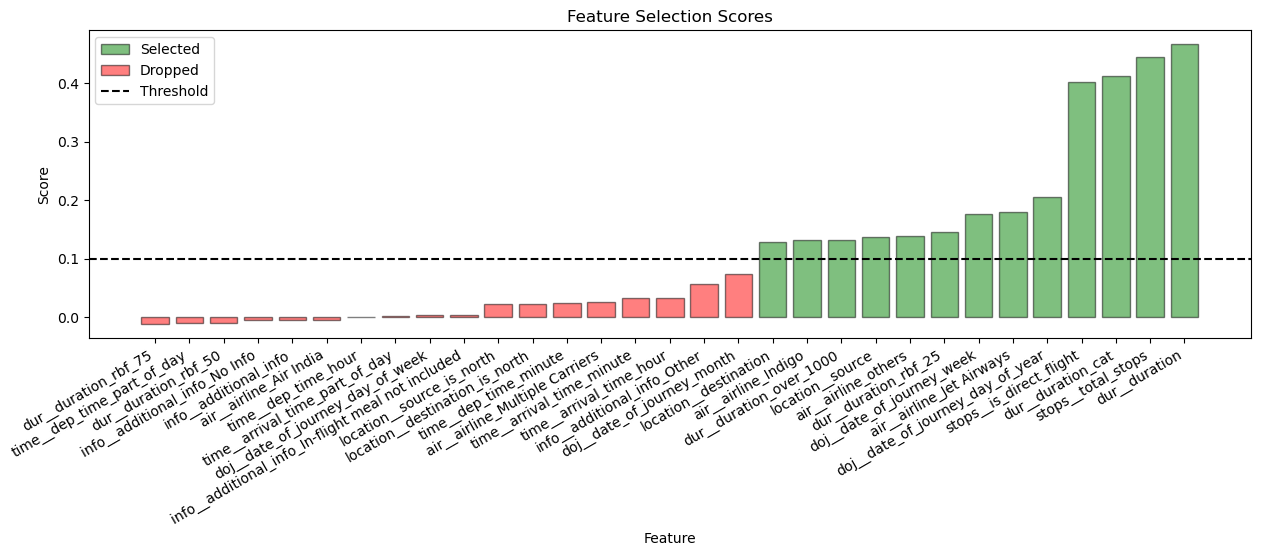

In [73]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()